<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/modelos_de_difusi%C3%B3n/difusi%C3%B3n_estable_con_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Difusión Estable (*Stable Diffusion*)

Stable Diffusion es un modelo de difusión latente de texto a imagen creado por investigadores e ingenieros de [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) y [LAION](https://laion.ai/). Está entrenado en imágenes de 512x512 de un subconjunto de la base de datos [LAION-5B](https://laion.ai/blog/laion-5b/). Este modelo utiliza un codificador de texto CLIP ViT-L/14 congelado para condicionar el modelo en las indicaciones de texto. Con su codificador de texto 860M UNet y 123M, el modelo es relativamente liviano y se ejecuta en una GPU con al menos 10 GB de VRAM.
Consulte la [tarjeta del modelo](https://huggingface.co/CompVis/stable-diffusion) para obtener más información.

Este *notebook* muestra cómo usar Stable Diffusion con [Hugging Face](https://github.com/huggingface/diffusers).

## 1. Cómo utilizar `StableDiffusionPipeline`

Previo a profundizar en los aspectos teóricos del funcionamiento de la difusión estable, es recomendable primero probar cómo se puede ejecutar la inferencia de texto a imagen en solo unas pocas líneas de código.

### Configuración

Primeramente se debe validar el uso de GPU y posteriormente se debe instalar `diffusers`, `scipy`, `ftfy` y `transformers`. Y `accelerate` se usa para lograr una carga mucho más rápida.

In [1]:
!nvidia-smi

Tue Feb 14 01:46:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.0 MB/s eta 0:00:00


### Canalización de difusión estable

`StableDiffusionPipeline` es una canalización de inferencia de extremo a extremo que puede usar para generar imágenes a partir de texto con solo unas pocas líneas de código.

En primer lugar, cargamos los pesos preentrenados de todos los componentes del modelo.

Existen algunas variantes del modelo que valen la pena probar como:
* [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). Esta versión puede producir imágenes con una resolución de 768x768, mientras que las otras funcionan a 512x512.

Además de la identificación del modelo [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), también se pueden definir los parámetros `revision` y `torch_dtype ` en el método `from_pretrained`.

In [4]:
import torch
from diffusers import StableDiffusionPipeline

In [15]:
%%time
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
# pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 18.3 s, sys: 24.7 s, total: 43 s
Wall time: 1min 19s


Para asegurarse de que Google Colab gratuito pueda ejecutar Stable Diffusion, se cargan los pesos de la rama de precisión media [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) y los pesos con precisión float16 pasando `torch_dtype=torch.float16`.

Si se desea garantizar la mayor precisión posible, se debe eliminar `revision="fp16"` y `torch_dtype=torch.float16` a costa de un mayor uso de memoria.

Se debe mover la canalización a la GPU para obtener una inferencia acelerada.

In [16]:
pipe = pipe.to("cuda")

El uso de `autocast` ejecutará la inferencia más rápido porque usa la mitad de precisión.

In [17]:
from torch import autocast

In [18]:
prompt = "baby dragon, depth of field,32k, natural light, ray tracing, ray tracing ambient light occlusion, anti-aliasing, elegant, hyper-realistic, super-detailed "

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 23.9 s, sys: 1.15 s, total: 25.1 s
Wall time: 26.1 s


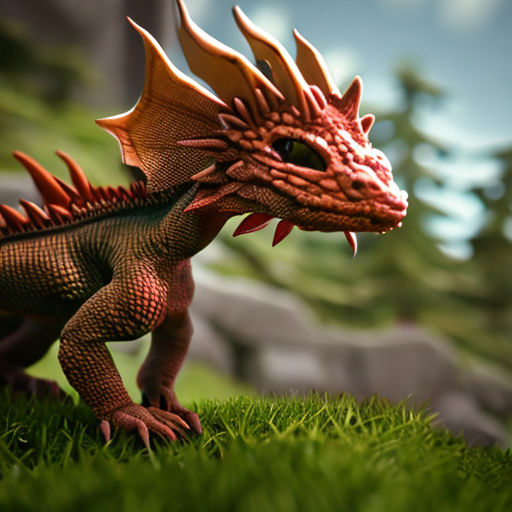

In [19]:
%%time
#with autocast("cuda"):
image = pipe(prompt).images[0]

image

Ejecutar la celda anterior varias veces dará una imagen diferente cada vez. Si se desea una salida determinista, se puede definir una semilla aleatoria dentro de la canalización. Cada vez que use la misma semilla se tendrá el mismo resultado generado.

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 23.3 s, sys: 953 ms, total: 24.2 s
Wall time: 25.5 s


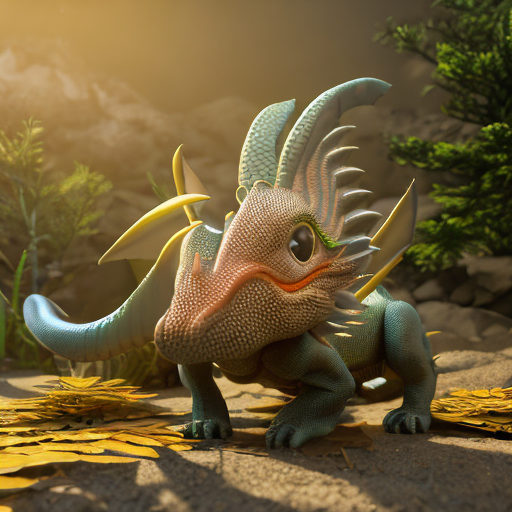

In [20]:
%%time
# with autocast("cuda"):
generator = torch.Generator("cuda").manual_seed(42)
image = pipe(prompt, generator=generator).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 24 s, sys: 1.05 s, total: 25.1 s
Wall time: 25.4 s


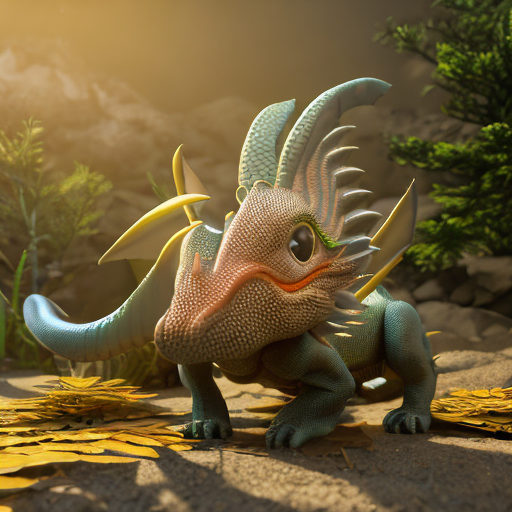

In [21]:
%%time
# with autocast("cuda"):
generator = torch.Generator("cuda").manual_seed(42)
image = pipe(prompt, generator=generator).images[0]

image

Es posible cambiar el número de pasos de inferencia usando el argumento `num_inference_steps`. En general, los resultados son mejores cuantos más pasos son utilizados. Es recomendable utilizar el valor predeterminado de '50'. Si se desea obtener resultados más rápidos, se puede utilizar un número menor. Por el contrario, si se desea mayor calidad, es recomendable incrementar su valor.

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 45.7 s, sys: 2.08 s, total: 47.8 s
Wall time: 49.7 s


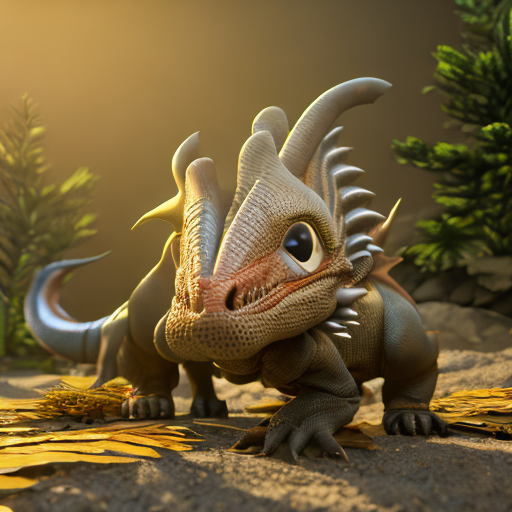

In [23]:
%%time
# with autocast("cuda"):
generator = torch.Generator("cuda").manual_seed(42)
image = pipe(prompt, num_inference_steps=100, generator=generator).images[0]

image

In [24]:
# Guardar una imagen generada
image.save("imagen_generada.png")

**Referencias**

* https://github.com/huggingface/diffusers/tree/main/src/diffusers/pipelines